## A/B Testing: Optimizing Marketing Strategies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t # Use the t-distribution for better accuracy with small samples
from scipy.stats import mannwhitneyu

In [2]:
# Load the A/B test data
df_control = pd.read_csv('../Data/ab_control_group.csv', sep=';')
df_test = pd.read_csv('../Data/ab_test_group.csv', sep=';')

In [3]:
df_control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


#### Wrangle Data

In [5]:
# Rename columns for clarity
df_control.columns = ['Campaign Name', 'Date', 'Amount Spend', 'Number of Impressions', 'Reach',
       'Website Clicks', 'Number of Searches', 'Content View',
       'Add to Cart', 'Purchase']

df_test.columns = ['Campaign Name', 'Date', 'Amount Spend', 'Number of Impressions', 'Reach',
       'Website Clicks', 'Number of Searches', 'Content View',
       'Add to Cart', 'Purchase']

| Old Column Name            | New Column Name     | Funnel Stage                     |
|----------------------------|---------------------|----------------------------------|
| Reach                      | Reach               | Top-of-Funnel (Awareness)        |
| Spend [USD]                | Amount Spend        | Cost Metric                      |
| # of Impressions           | Number of Impressions | Top-of-Funnel (Awareness)      |
| # of Website Clicks        | Website Clicks      | Top-of-Funnel (Engagement)       |
| # of Searches              | Number of Searches  | Middle-of-Funnel (Consideration) |
| # of View Content          | Content View        | Middle-of-Funnel (Interaction)   |
| # of Add to Cart           | Add to Cart         | Middle-of-Funnel (Intent)        |
| # of Purchase              | Purchase            | Bottom-of-Funnel (Conversion)    |

In [6]:
# check for missing values
print(df_control[df_control.isnull().any(axis=1)].to_string())
print("\n")
print(df_test[df_test.isnull().any(axis=1)].to_string())

      Campaign Name       Date  Amount Spend  Number of Impressions  Reach  Website Clicks  Number of Searches  Content View  Add to Cart  Purchase
4  Control Campaign  5.08.2019          1835                    NaN    NaN             NaN                 NaN           NaN          NaN       NaN


Empty DataFrame
Columns: [Campaign Name, Date, Amount Spend, Number of Impressions, Reach, Website Clicks, Number of Searches, Content View, Add to Cart, Purchase]
Index: []


In [7]:
df_control = df_control.dropna()
df_control.reset_index(drop=True, inplace=True)
df_control.shape

(29, 10)

In [8]:
# check for any missing values in each column
print(df_control.isna().sum().any())
print(df_test.isna().sum().any())

False
False


### Metrics Selection

**Initial Engagement (Top-of-Funnel)**

| Metric          | Calculation                      | Purpose                                                                                  |
|-----------------|---------------------------------|------------------------------------------------------------------------------------------|
| CPC (Cost per Click) | Amount Spent / Purchase | measures how efficiently you buy visits from impressions. |
| CTR (Click-Through Rate) | Website Clicks / Number of Impressions | Identifies high-performing ad creatives and targeting by measuring the percentage of viewers who click. |
| Website Clicks  | Raw count of clicks             | Measures initial user engagement/interest and traffic driven.                            |
| Content Viewed  | Number of pages or content viewed after the initial click | Measures user activity and confirms that the click led to the intended content.          |

**Intent & Consideration (Middle-of-Funnel)**

| Metric            | Definition                                    | Purpose                                                                                  |
|-------------------|-----------------------------------------------|------------------------------------------------------------------------------------------|
| Searches Received | Internal searches on the website              | Measures website interaction and indicates strong product consideration.                |
| Added to Cart     | Count of items placed in the shopping cart    | Indicates a strong intent to purchase; a crucial step before conversion.                 |
| CR (Conversion Rates) | Calculated ratios (e.g., Added to Cart / Website Clicks) | Measures funnel stage efficiency and highlights where user drop-off occurs (e.g., a high number of clicks but low "Added to Cart" rate). |

**Transaction & Cost (Bottom-of-Funnel)**

| Metric               | Calculation              | Purpose                                                                 |
|-----------------------|--------------------------|--------------------------------------------------------------------------|
| Purchases             | Final count of completed transactions. | Measures the complete transaction—the primary conversion goal. |
| CPA (Cost Per Acquisition) | Amount Spent / Purchases | Determines the profitability of advertising campaigns; ensures acquisition cost is below customer value. |


In [9]:
# define random seed for reproducibility
SEED = 1776
np.random.seed(SEED)


# Define metrics to analyze
metrics = ['Website Clicks', 'Number of Searches', 'Add to Cart', 'Purchase', \
           'Content View', 'CPC', 'CR', 'CPA', 'CTR']

In [10]:
def safe_divide_and_fill(data, numerator_col, denominator_col, new_col_name):
    """
    Calculates a new ratio column, handles division by zero (inf), 
    replaces inf/-inf with NaN, and then fills NaNs with the mean of the new column.
    """
    # 1. Calculate the ratio
    data[new_col_name] = data[numerator_col] / data[denominator_col]
    
    # 2. Clean the data
    # Replace division by zero errors (inf, -inf) with NaN
    data[new_col_name] = data[new_col_name].replace([np.inf, -np.inf], np.nan)
    
    # 3. Fill missing values (including the ones created above) with the column mean
    data[new_col_name] = data[new_col_name].fillna(data[new_col_name].mean())
    
    return data

def preprocess_data_optimized(data):
    # Ensure we work on a copy to prevent SettingWithCopyWarning
    data = data.copy()
    
    # --- Define the list of operations ---
    # (Numerator, Denominator, New Metric Name)
    metrics_to_calculate = [
        ('Amount Spend', 'Purchase', 'CPA'), # Cost Per Acquisition
        ('Website Clicks', 'Number of Impressions', 'CTR'), # Click Through Rate
        ('Add to Cart', 'Website Clicks', 'CR'), # Conversion Rate
        ('Amount Spend', 'Purchase', 'CPC'), # Cost Per Click
    ]

    # --- Apply the operations using the helper function ---
    for num, den, name in metrics_to_calculate:
        data = safe_divide_and_fill(data, num, den, name)
        
    return data

In [11]:
# Preprocessing of both datasets
df_control_new = preprocess_data_optimized(df_control)
df_test_new = preprocess_data_optimized(df_test)

In [12]:
df_control_new.head()

,Campaign Name,Date,Amount Spend,Number of Impressions,Reach,Website Clicks,Number of Searches,Content View,Add to Cart,Purchase,CPA,CTR,CR,CPC
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,3.689320,0.084835,0.259265,3.689320
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,3.438356,0.067003,0.150308,3.438356
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,6.298387,0.049411,0.174247,6.298387
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,5.705882,0.042057,0.385971,5.705882
4,Control Campaign,6.08.2019,3083,109076.0,87998.0,4028.0,1709.0,1249.0,784.0,764.0,4.035340,0.036928,0.194638,4.035340


In [13]:
df_test_new.head()

,Campaign Name,Date,Amount Spend,Number of Impressions,Reach,Website Clicks,Number of Searches,Content View,Add to Cart,Purchase,CPA,CTR,CR,CPC
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255,11.796078,0.076814,0.294273,11.796078
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677,3.754801,0.046238,0.188748,3.754801
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578,4.091696,0.112221,0.160812,4.091696
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340,7.970588,0.053741,0.134250,7.970588
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768,2.990885,0.051297,0.163056,2.990885


In [14]:
def perform_normality_variance_test(data_a, data_b, metric):
    """
    Perform Shapiro-Wilk test for normality & Levene test for equal variances 
    on two datasets for a given metric including Q-Q plots.
    Returns the p-values for both datasets.
    """
    # dictionary
    results = {}
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) # Increased figsize for better visibility

    # Plot for A on the first subplot (ax1)
    stats.probplot(data_a[metric], dist="norm", plot=ax1)
    ax1.set_title(f'QQ A for {metric}')

    # Plot for B on the second subplot (ax2)
    stats.probplot(data_b[metric], dist="norm", plot=ax2)
    ax2.set_title(f'QQ B for {metric}')

    # Adjust layout to prevent overlapping titles/labels
    plt.tight_layout()
    plt.show()

    # Perform Shapiro-Wilk test for normality
    stat_a, p_value_a = stats.shapiro(data_a[metric])
    stat_b, p_value_b = stats.shapiro(data_b[metric])
    print(f"Shapiro-Wilk test for {metric}: A p-value={p_value_a:.3f}, B p-value={p_value_b:.3f}")

    # Perform noramality testmality test
    stat_a, p_value_a = stats.normaltest(data_a[metric])
    stat_b, p_value_b = stats.normaltest(data_b[metric])
    print(f"Normal test for {metric}: A p-value={p_value_a:.3f}, B p-value={p_value_b:.3f}")
    print("\n")  
    
    # Perform Levene test for equal variances
    stat_levene, p_value_levene = stats.levene(data_a[metric], data_b[metric])
    print(f"Levene test for {metric}: stat={stat_levene:.3f}, p-value={p_value_levene:.3f}")
    # Calculate and print variances
    var1 = np.var(data_a[metric], ddof=1)
    var2 = np.var(data_b[metric], ddof=1)
    print(f"A variance: {var1:.3f}, B variance: {var2:.3f}")
    print("-"*150)

    # Store results in dictionary
    results['metric'] = metric
    results['shapiro_a_p'] = p_value_a
    results['shapiro_b_p'] = p_value_b
    results['normaltest_a_p'] = p_value_a
    results['normaltest_b_p'] = p_value_b
    results['levene_p'] = p_value_levene
    results['var_a'] = var1
    results['var_b'] = var2
    
    return results

In [15]:
def perform_t_test(A, B, alpha = 0.05, equal_var=True):
    # Use pooled t-test only if variances are equal and sample sizes are similar.
    # Perform two-sample t-test (equal_var=True or False based on Levene's test)
    t_stat, p_value = stats.ttest_ind(A, B, equal_var=equal_var)
    print(f"Pooled t-test t-statistic: {t_stat:.3f}")
    print(f"Pooled t-test p-value: {p_value:.3f}")

    # Interpretation
    # --- Conclusion ---
    if p_value < alpha:
        if p_value < alpha:
            print(f"\n✅ Conclusion: Reject the Null Hypothesis (p < {alpha}).")
            print(f"The mean of Group B ({np.mean(B):.2f}) is statistically significantly different from Group A ({np.mean(A):.2f}).")
        else:
            print(f"\nConclusion: Fail to Reject the Null Hypothesis (p >= {alpha}).")
            print(f"There is not enough evidence to say the mean of Group B is different from Group A.")

In [16]:
def bayesian_t_test_equivalent(A, B, metric, seed=SEED,N_SAMPLES=100_000):

    # for reproducibility
    np.random.seed(seed)
    # --- 1. Calculate Standard Errors (The Uncertainty) ---
    # Standard error is the standard deviation of the sampling distribution of the mean.
    A_mean = np.mean(A[metric])
    B_mean = np.mean(B[metric])

    A_std = np.std(A[metric], ddof=1)  # Sample standard deviation
    B_std = np.std(B[metric], ddof=1)  # Sample standard deviation

    se_A = A_std / np.sqrt(len(A[metric]))
    se_B = B_std / np.sqrt(len(B[metric]))

    # --- 2. Degrees of Freedom (dof) for the t-distribution
    # Using n-1 for a simpler approximation
    dof_A = len(A[metric]) - 1
    dof_B = len(B[metric]) - 1

    # Monte Carlo Simulation (Approximating the Posterior)
    # Approximate the Posterior Distribution of the Mean (mu) for each group
    # We sample from the t-distribution centered at the sample mean (mean_A/B) 
    # and scaled by the standard error (se_A/B).
    samples_A = t.rvs(df=dof_A, loc=A_mean, scale=se_A, size=N_SAMPLES)
    samples_B = t.rvs(df=dof_B, loc=B_mean, scale=se_B, size=N_SAMPLES)

    # --- 4. Parameter of Interest: Difference and Superiority ---
    diff_samples = samples_B - samples_A

    # Calculate the 95% Credible Interval (CrI)
    hdi_diff = np.percentile(diff_samples, [2.5, 97.5])

    # Calculate the Probability of Superiority (P(mu_B > mu_A))
    # This is the proportion of times the difference is positive.
    prob_b_better = (diff_samples > 0).mean()

    # --- 5. Analysis and Interpretation ---
    print(f"\n--- Bayesian T-Test Equivalent Results (Monte Carlo) N_SAMPLES={N_SAMPLES:,} ---")
    print("Ratio of stds (B/A):", B_std / A_std)
    print(f"Mean Difference (B - A): {np.mean(diff_samples):.2f}")
    print(f"95% Credible Interval (CrI) for Difference: [{hdi_diff[0]:.2f}, {hdi_diff[1]:.2f}]")
    print(f"Probability B > A (P(mu_B > mu_A)): {prob_b_better:.4f} ({prob_b_better:.2%})")

    # --- Conclusion ---
    # Interpret the CrI, which is the key to Bayesian hypothesis testing.
    if hdi_diff[0] > 0:
        print("\n✅ Conclusion: The entire 95% CrI is positive. Variant B is highly likely to be superior to A.")
    elif hdi_diff[0] < 0 and hdi_diff[1] > 0:
        print("\n⚠️ Conclusion: The 95% CrI crosses zero. The evidence is not conclusive; more data is needed.")
    else:
        print("\n❌ Conclusion: The 95% CrI is entirely negative. Variant A is likely superior to B (or B is inferior).")

✅ Final Conclusion Summary
- High Probability of Superiority ($P(\mu_B > \mu_A)$): The probability that the true mean of Variant B is higher than the true mean of Variant A is 99.58%. This level of certainty is exceptionally high, providing strong evidence against the null hypothesis of no difference.
- Positive Credible Interval (CrI): The $\mathbf{95\% \text{ Credible Interval (CrI)}}$ for the difference in means $(\mu_B - \mu_A)$ is $[\mathbf{70.29}, \mathbf{447.74}]$.
    - Since zero is not included in this interval (the entire interval is positive), you are 95% certain that the true effect of Variant B is an improvement over Variant A.
- Estimated Effect Size: The best estimate for the true improvement is 259.13 units (the Mean Difference).


=== Analyzing Metric: Website Clicks ===


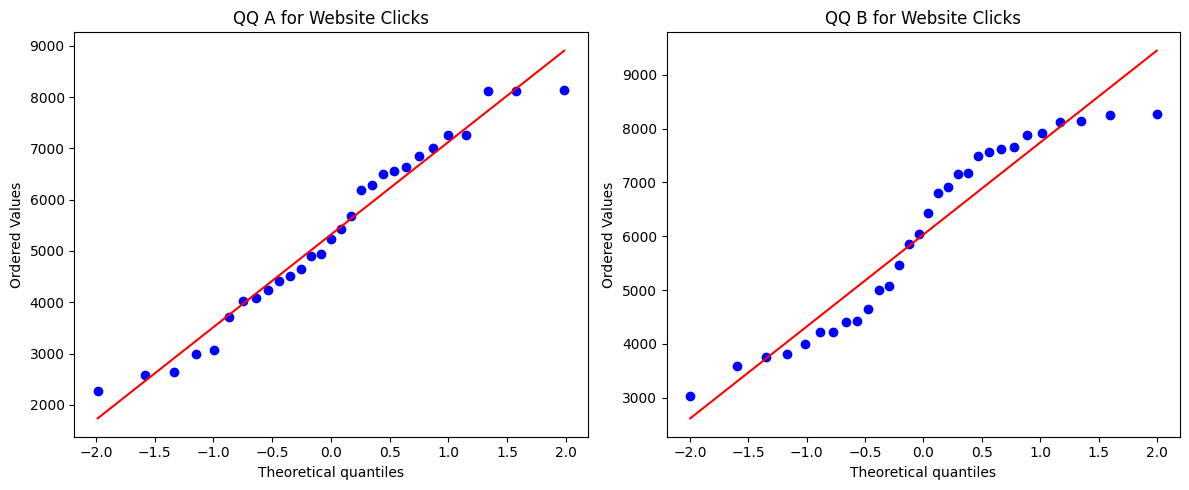

Shapiro-Wilk test for Website Clicks: A p-value=0.304, B p-value=0.012
Normal test for Website Clicks: A p-value=0.223, B p-value=0.001


Levene test for Website Clicks: stat=0.042, p-value=0.839
A variance: 3088345.813, B variance: 2919202.092
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: Number of Searches ===


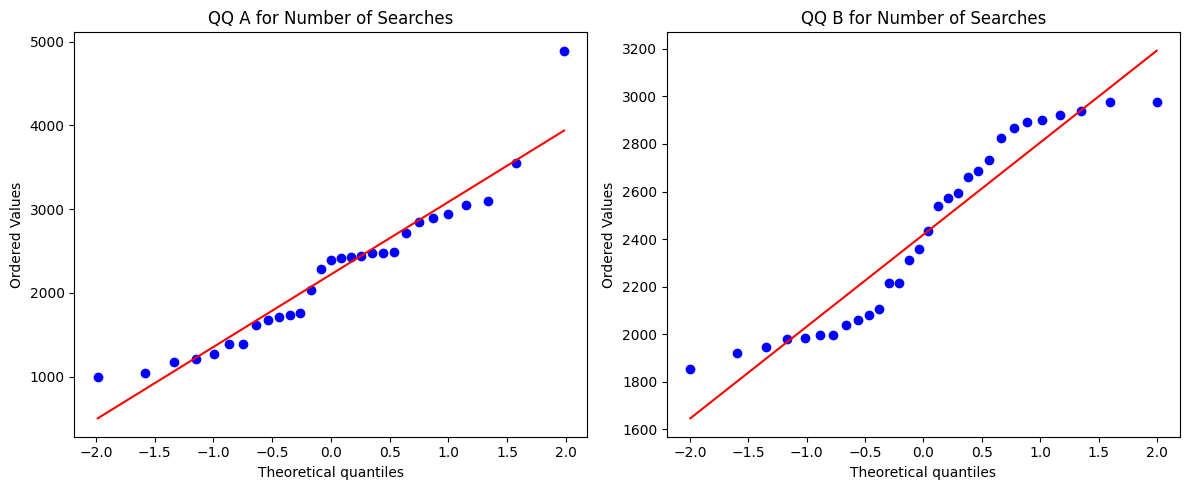

Shapiro-Wilk test for Number of Searches: A p-value=0.050, B p-value=0.007
Normal test for Number of Searches: A p-value=0.028, B p-value=0.000


Levene test for Number of Searches: stat=9.063, p-value=0.004
A variance: 750110.793, B variance: 151120.585
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: Add to Cart ===


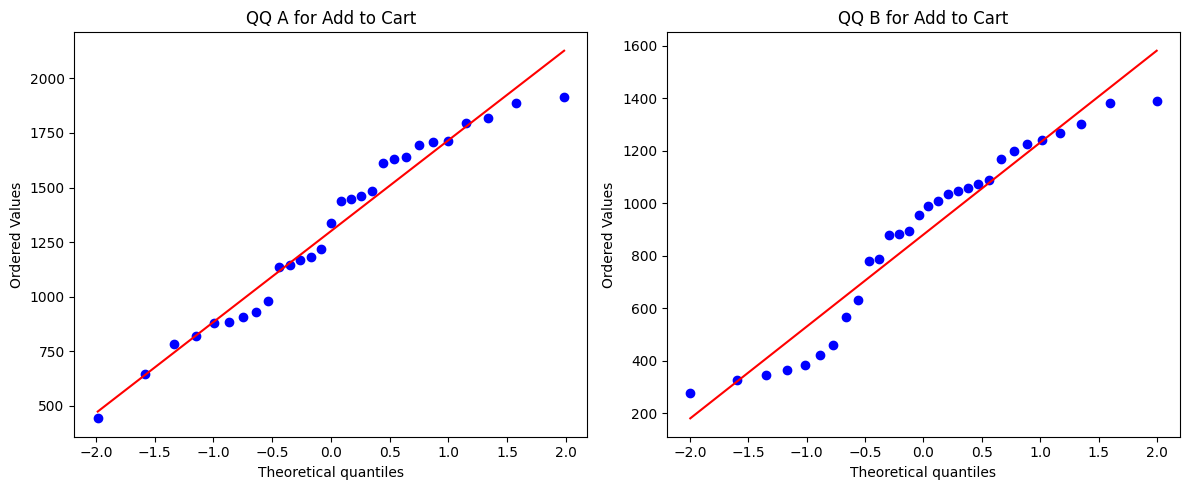

Shapiro-Wilk test for Add to Cart: A p-value=0.252, B p-value=0.033
Normal test for Add to Cart: A p-value=0.237, B p-value=0.083


Levene test for Add to Cart: stat=1.429, p-value=0.237
A variance: 166022.000, B variance: 120814.809
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: Purchase ===


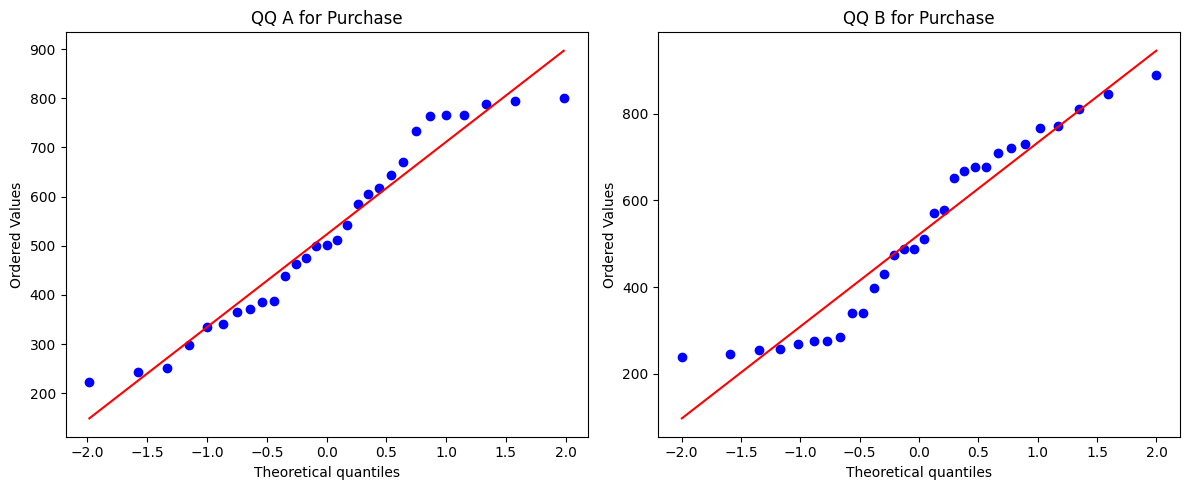

Shapiro-Wilk test for Purchase: A p-value=0.090, B p-value=0.024
Normal test for Purchase: A p-value=0.056, B p-value=0.005


Levene test for Purchase: stat=1.230, p-value=0.272
A variance: 34235.599, B variance: 44541.151
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: Content View ===


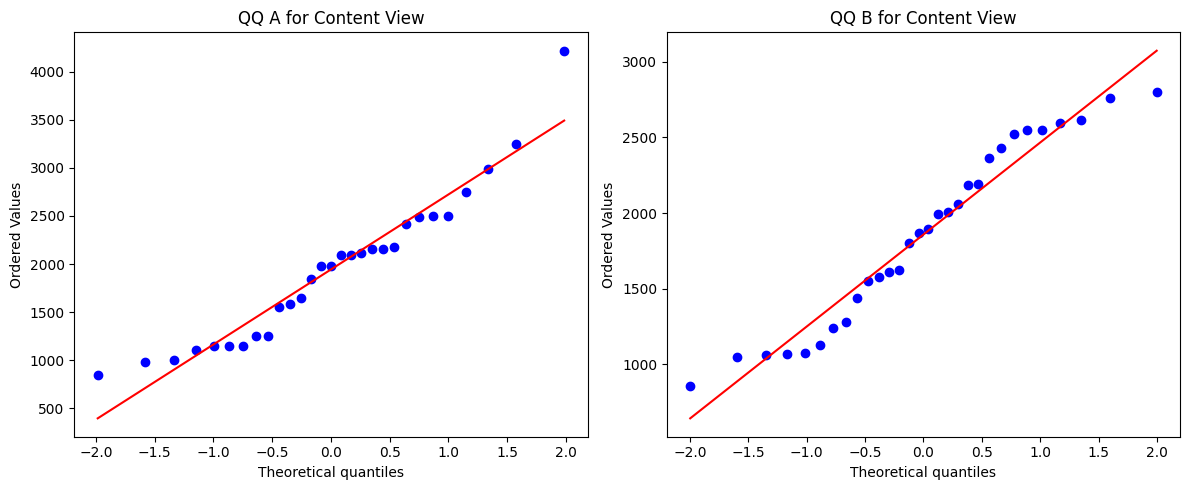

Shapiro-Wilk test for Content View: A p-value=0.069, B p-value=0.093
Normal test for Content View: A p-value=0.064, B p-value=0.026


Levene test for Content View: stat=0.769, p-value=0.384
A variance: 604576.956, B variance: 357191.103
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: CPC ===


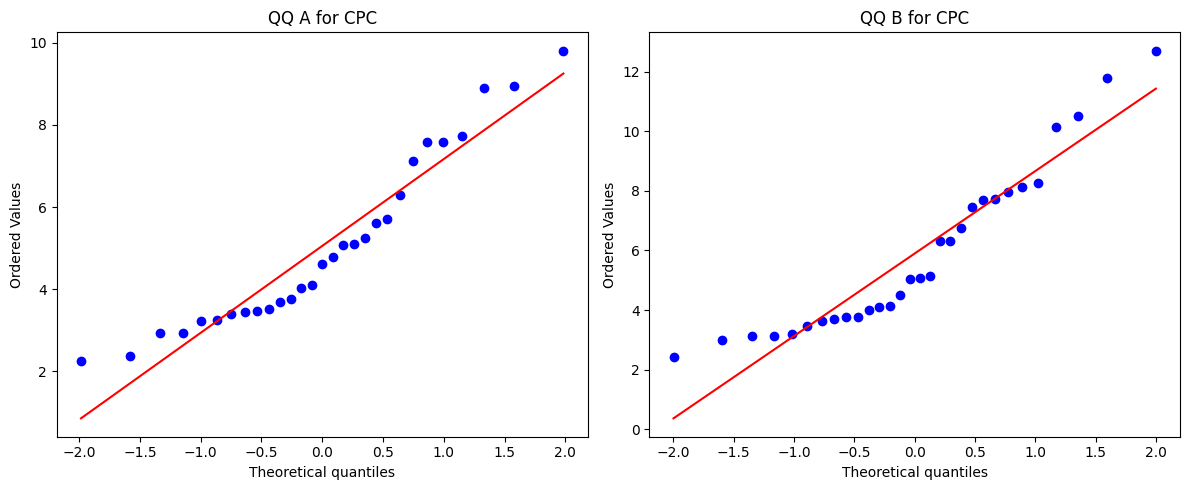

Shapiro-Wilk test for CPC: A p-value=0.021, B p-value=0.007
Normal test for CPC: A p-value=0.188, B p-value=0.117


Levene test for CPC: stat=1.698, p-value=0.198
A variance: 4.482, B variance: 7.844
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: CR ===


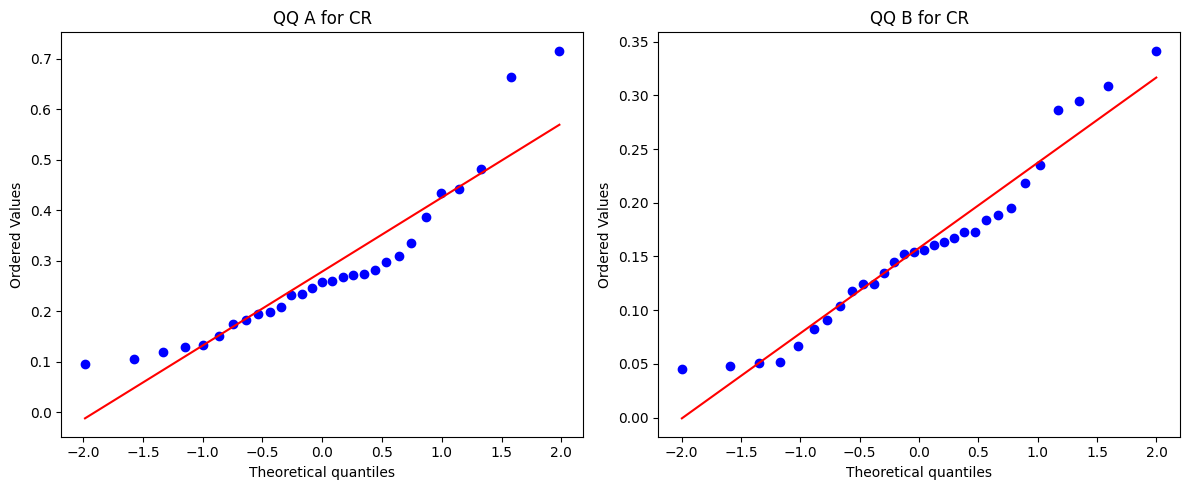

Shapiro-Wilk test for CR: A p-value=0.002, B p-value=0.111
Normal test for CR: A p-value=0.002, B p-value=0.318


Levene test for CR: stat=4.183, p-value=0.045
A variance: 0.023, B variance: 0.006
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: CPA ===


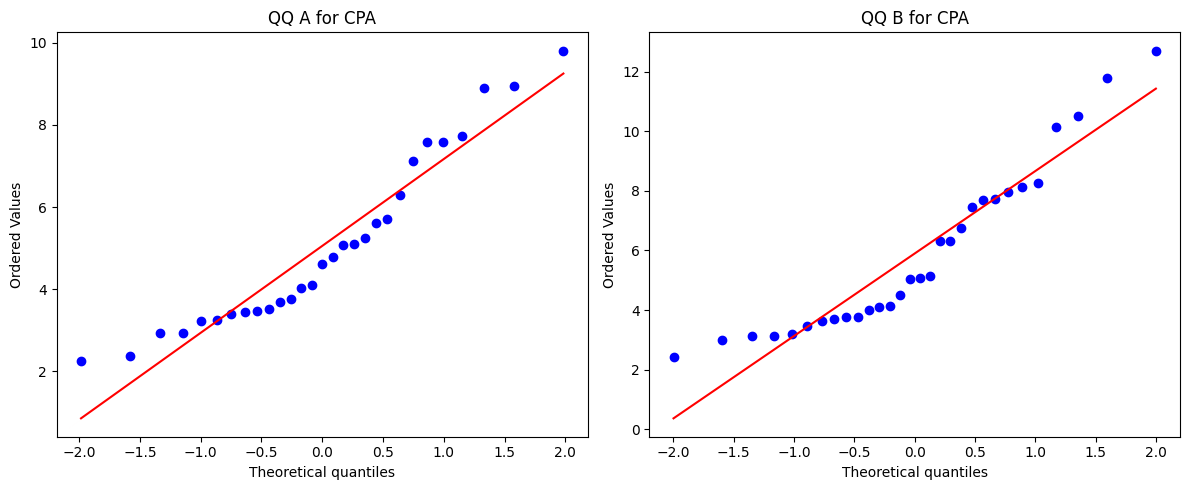

Shapiro-Wilk test for CPA: A p-value=0.021, B p-value=0.007
Normal test for CPA: A p-value=0.188, B p-value=0.117


Levene test for CPA: stat=1.698, p-value=0.198
A variance: 4.482, B variance: 7.844
------------------------------------------------------------------------------------------------------------------------------------------------------

=== Analyzing Metric: CTR ===


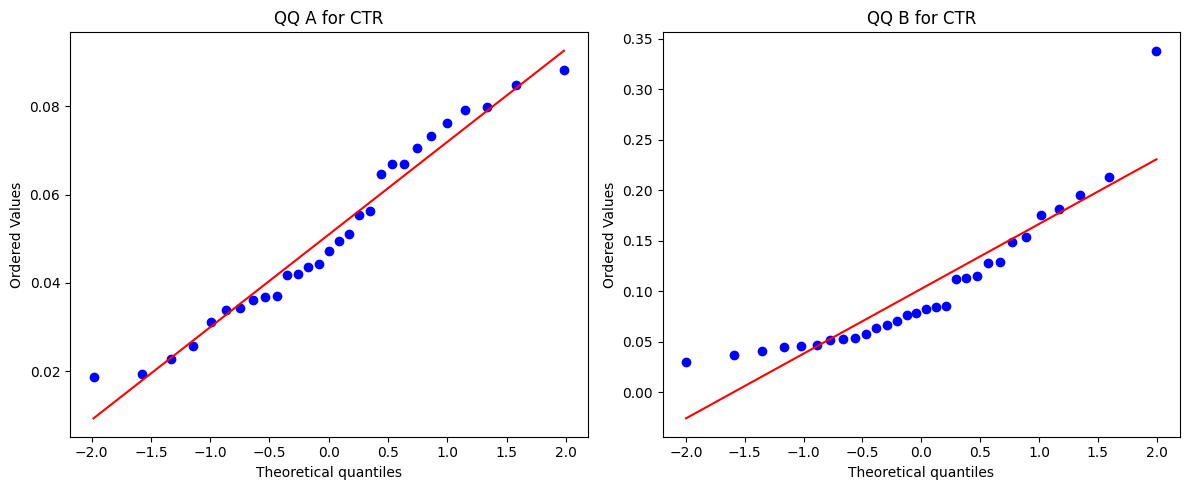

Shapiro-Wilk test for CTR: A p-value=0.245, B p-value=0.000
Normal test for CTR: A p-value=0.167, B p-value=0.000


Levene test for CTR: stat=9.708, p-value=0.003
A variance: 0.000, B variance: 0.005
------------------------------------------------------------------------------------------------------------------------------------------------------


In [17]:
# Analyze each metric
for i, metric in enumerate(metrics):
    print(f"\n=== Analyzing Metric: {metric} ===")
    if i == 0:
        data = perform_normality_variance_test(df_control_new, df_test_new, metric)
        df_data = pd.DataFrame([data])
    else:
        data = perform_normality_variance_test(df_control_new, df_test_new, metric)
        df_data = pd.concat([df_data, pd.DataFrame([data])], ignore_index=True)

In [18]:
df_data

,metric,shapiro_a_p,shapiro_b_p,normaltest_a_p,normaltest_b_p,levene_p,var_a,var_b
0,Website Clicks,0.222580,0.000645,0.222580,0.000645,0.838549,3.088346e+06,2.919202e+06
1,Number of Searches,0.027686,0.000097,0.027686,0.000097,0.003882,7.501108e+05,1.511206e+05
2,Add to Cart,0.236677,0.082808,0.236677,0.082808,0.236862,1.660220e+05,1.208148e+05
3,Purchase,0.055742,0.005376,0.055742,0.005376,0.272014,3.423560e+04,4.454115e+04
4,Content View,0.064354,0.025559,0.064354,0.025559,0.384204,6.045770e+05,3.571911e+05
5,CPC,0.188364,0.116616,0.188364,0.116616,0.197849,4.481776e+00,7.844288e+00
6,CR,0.001500,0.317993,0.001500,0.317993,0.045452,2.288546e-02,6.136789e-03
7,CPA,0.188364,0.116616,0.188364,0.116616,0.197849,4.481776e+00,7.844288e+00
8,CTR,0.167320,0.000079,0.167320,0.000079,0.002871,4.205654e-04,4.584505e-03


This small size has significant implications for the reliability and choice of statistical tests, particularly concerning the assumption of normality that we've been discussing for your AB test metrics (Purchase, CPC, Content View, and etc.). The small size means that the Central Limit Theorem (CLT)—which states that the sampling distribution of the mean tends toward a normal distribution as the sample size increases—does not fully apply.
- Impact: When $N$ is small, statistical tests that assume an underlying normal distribution (like the Independent Samples $t$-test) are less robust to violations of this assumption.
- This reinforces why the results of your Shapiro-Wilk test are so important. If the Shapiro-Wilk test rejects the null hypothesis of normality is not consistant throughout the metrics we are testing, therefore we should use the Mann-Whitney U Test over a $t$-test since the Levene's test for homogeneity of variances, have low statistical power with small samples. Although our Levene's tests came back non-significant ($p > 0.05$), it's wise to acknowledge that the test may be underpowered.

In [19]:
def perform_mannwhitneyu_test(data_a, data_b, metric, alpha, seed=SEED):
    """
    Perform Mann-Whitney U Test on two independent samples.
    Args:
        group_a_data (array-like): Data for Group A.
        group_b_data (array-like): Data for Group B.
        N (int): Sample size for each group.
        seed (int): Random seed for reproducibility.
    """
    # Mann-Whitney U Test Implementation
    np.random.seed(seed) # for reproducibility

    # Perform the Mann-Whitney U Test
    # The 'alternative' parameter specifies the nature of the difference (two-sided, less, or greater)
    # We typically use 'two-sided' for a general AB test to detect a difference in either direction.
    u_statistic, p_value = mannwhitneyu(
        x=data_a[metric],
        y=data_b[metric],
        alternative='two-sided',
        method='auto' # automatically selects appropriate method for large/small samples
    )

    # Print the results

    print(f"--- Mann-Whitney U Test Results ---")
    print(f"Group A Median: {np.median(data_a[metric]):.3f}")
    print(f"Group B Median: {np.median(data_b[metric]):.3f}")
    print(f"U Statistic: {u_statistic:.3f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significance Level (alpha): {alpha}")

    # 4. Interpret the result
    if p_value <= alpha:
        print("\n✅ CONCLUSION: Reject the Null Hypothesis (H0).")
        print("There is a statistically significant difference in the distributions (or medians) of the metric between Group A and Group B.")
    else:
        print("\nCONCLUSION: Fail to Reject the Null Hypothesis (H0).")
        print("There is insufficient evidence to conclude a statistically significant difference.")

In [20]:
# Analyze each metric
for i, metric in enumerate(metrics):
    print(f"\n=== Analyzing Metric: {metric} ===")
    perform_mannwhitneyu_test(df_control_new, df_test_new, metric, 0.05, SEED)


=== Analyzing Metric: Website Clicks ===
--- Mann-Whitney U Test Results ---
Group A Median: 5224.000
Group B Median: 6242.500
U Statistic: 337.000
P-value: 0.1393
Significance Level (alpha): 0.05

CONCLUSION: Fail to Reject the Null Hypothesis (H0).
There is insufficient evidence to conclude a statistically significant difference.

=== Analyzing Metric: Number of Searches ===
--- Mann-Whitney U Test Results ---
Group A Median: 2390.000
Group B Median: 2395.500
U Statistic: 346.000
P-value: 0.1796
Significance Level (alpha): 0.05

CONCLUSION: Fail to Reject the Null Hypothesis (H0).
There is insufficient evidence to conclude a statistically significant difference.

=== Analyzing Metric: Add to Cart ===
--- Mann-Whitney U Test Results ---
Group A Median: 1339.000
Group B Median: 974.000
U Statistic: 664.000
P-value: 0.0005
Significance Level (alpha): 0.05

✅ CONCLUSION: Reject the Null Hypothesis (H0).
There is a statistically significant difference in the distributions (or medians) of

In [21]:
# Analyze each metric
for i, metric in enumerate(metrics):
    print(f"\n=== Analyzing Metric: {metric} ===")
    bayesian_t_test_equivalent(df_control_new, df_test_new, metric, SEED)


=== Analyzing Metric: Website Clicks ===

--- Bayesian T-Test Equivalent Results (Monte Carlo) N_SAMPLES=100,000 ---
Ratio of stds (B/A): 0.972230225970925
Mean Difference (B - A): 712.19
95% Credible Interval (CrI) for Difference: [-206.19, 1630.14]
Probability B > A (P(mu_B > mu_A)): 0.9364 (93.64%)

⚠️ Conclusion: The 95% CrI crosses zero. The evidence is not conclusive; more data is needed.

=== Analyzing Metric: Number of Searches ===

--- Bayesian T-Test Equivalent Results (Monte Carlo) N_SAMPLES=100,000 ---
Ratio of stds (B/A): 0.4488478052326868
Mean Difference (B - A): 197.93
95% Credible Interval (CrI) for Difference: [-161.87, 555.83]
Probability B > A (P(mu_B > mu_A)): 0.8644 (86.44%)

⚠️ Conclusion: The 95% CrI crosses zero. The evidence is not conclusive; more data is needed.

=== Analyzing Metric: Add to Cart ===

--- Bayesian T-Test Equivalent Results (Monte Carlo) N_SAMPLES=100,000 ---
Ratio of stds (B/A): 0.8530554570170201
Mean Difference (B - A): -418.32
95% Credib

## Conclusion
- Across both the Mann–Whitney U tests (non‑parametric) and the Bayesian t‑tests, only Click‑Through Rate (CTR) showed a statistically and practically significant difference between variants.
- No other funnel metrics demonstrated consistent evidence of a difference, so the experiment’s impact is interpreted as a meaningful lift in CTR only, with other metrics treated as inconclusive or null at this time.